In [261]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor  # pip install xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgbexcel import XGBtoExcel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


In [262]:
!pip install xgbexcel


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Считывание данных

In [263]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

Функция для нормализации предсказаний

Предсказаний меньше нуля никак не может быть, так что мы можем ограничить все предсказания

In [264]:
warnings.filterwarnings("ignore")

Отключение предупреждений от моделей

In [265]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

Установка рабочей директории (тк данные располагаются на папку выше)

In [266]:
data = pd.read_excel("raw_data/Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

In [267]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

Считывание данных

# Предобработка данных

In [268]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [269]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

Получаем все колонки, связанные с "Удельный расход условного топлива на отпуск э/э гр.130"

In [270]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

## Добавление фич даты

In [271]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

Разделяем значение даты на день/месяц/год

In [272]:
date = date[1:]

In [273]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [274]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [275]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [276]:
data = data.drop(["Дата"], axis=1)

In [277]:
data.isna().sum()

Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
year                                                         0
month                                                        0
day                                                          0
dtype: int64

In [278]:
data = data[columns_for_predictions + ["day", "month", "year"]]

# Обработка выбросов

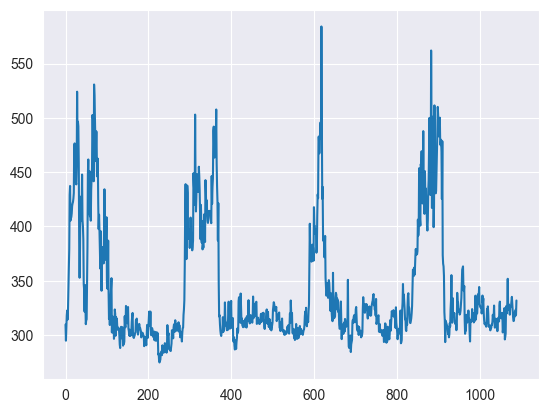

In [279]:
plt.plot(data[target]);

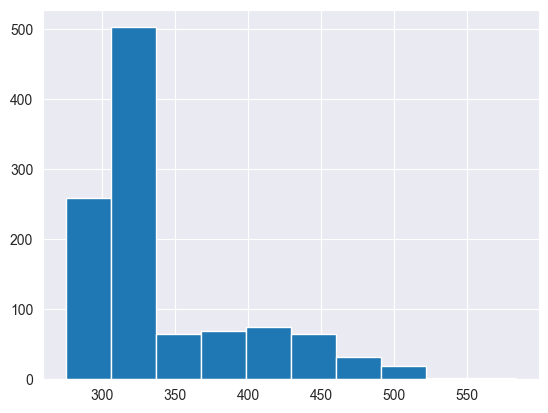

In [280]:
plt.hist(data[target]);

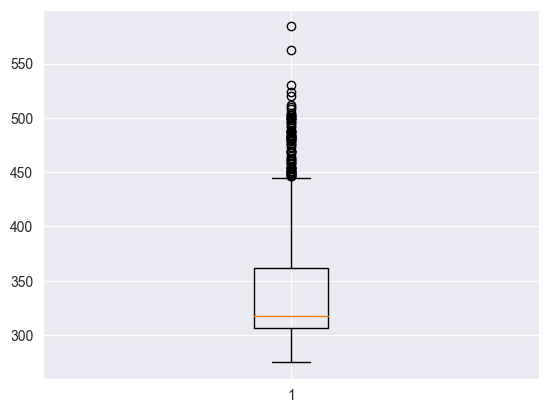

In [281]:
plt.boxplot(data[target]);

In [282]:
data = data.loc[data[target] < 500]
data = data.loc[data[target] > 100]

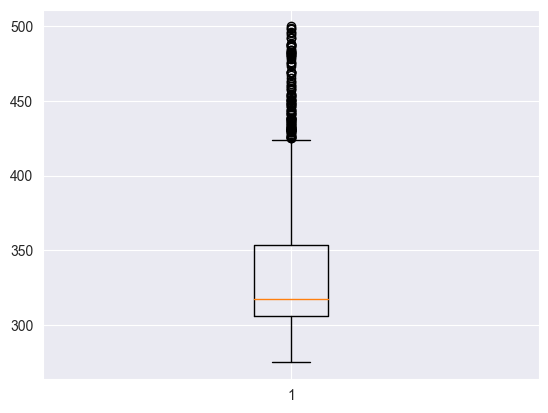

In [283]:
plt.boxplot(data[target]);

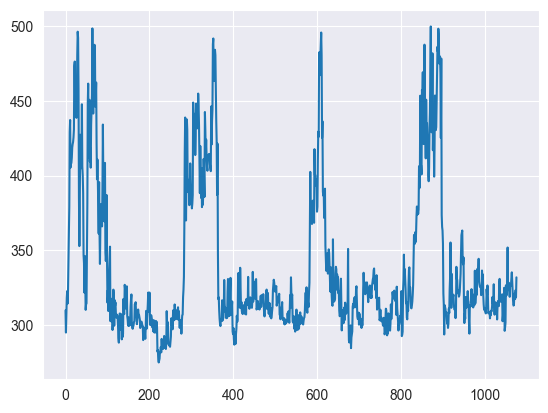

In [284]:
plt.plot(np.array(data[target]));

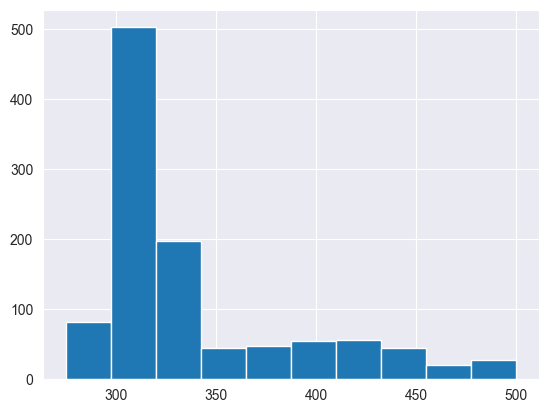

In [285]:
plt.hist(data[target]);

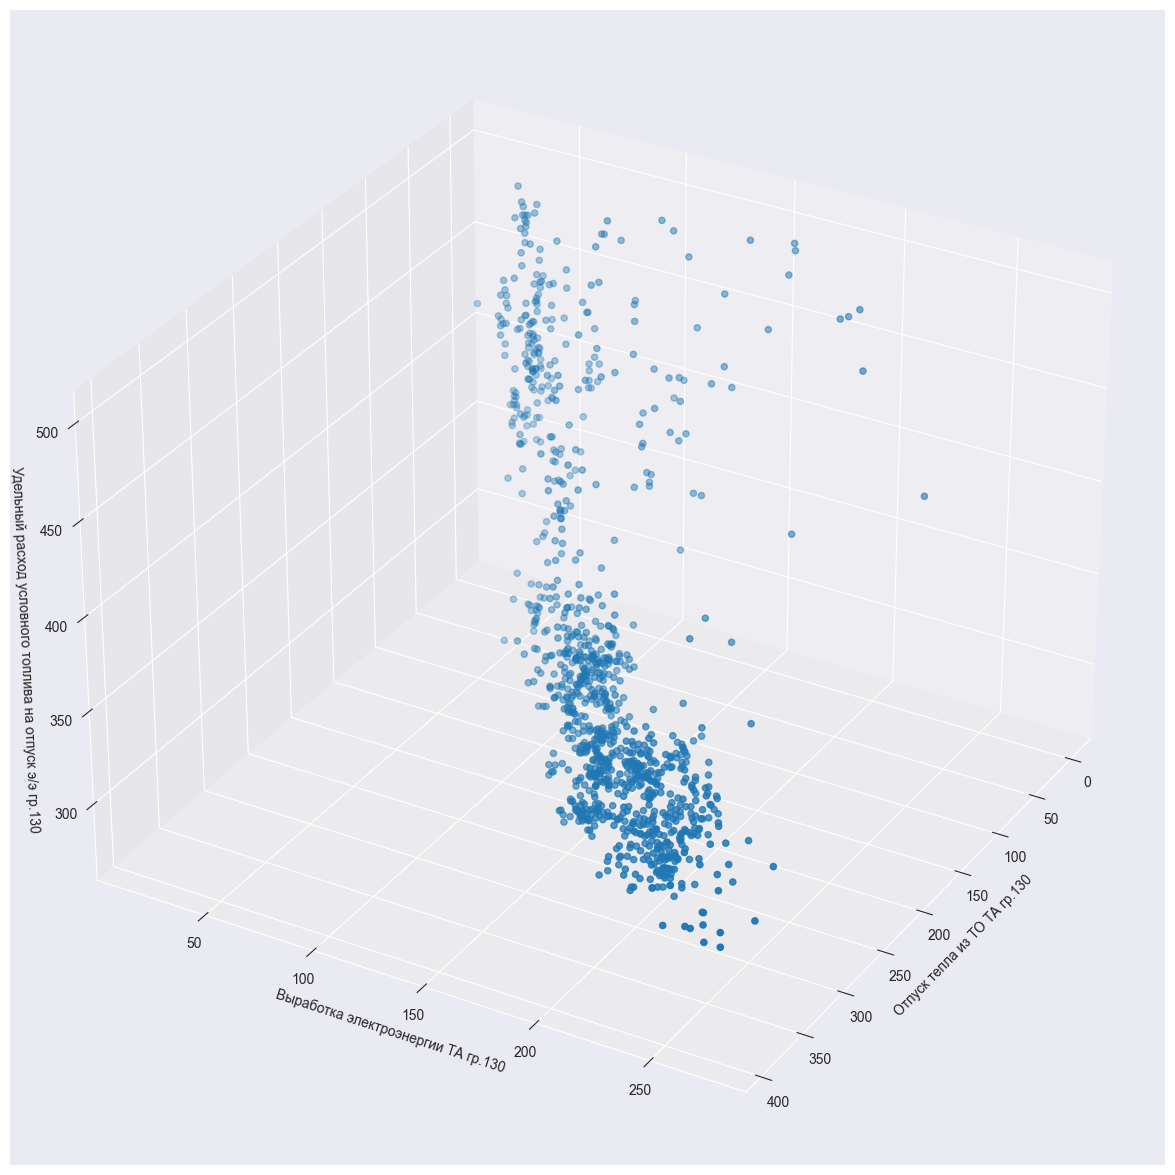

In [286]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.set_figheight(15)
fig.set_figwidth(15)
ax.scatter(
    data[columns_for_predictions[1]],
    data[columns_for_predictions[0]],
    data[columns_for_predictions[2]]
)

ax.view_init(30, 30)
ax.set_xlabel(columns_for_predictions[1])
ax.set_ylabel(columns_for_predictions[0])
ax.set_zlabel(columns_for_predictions[2]);

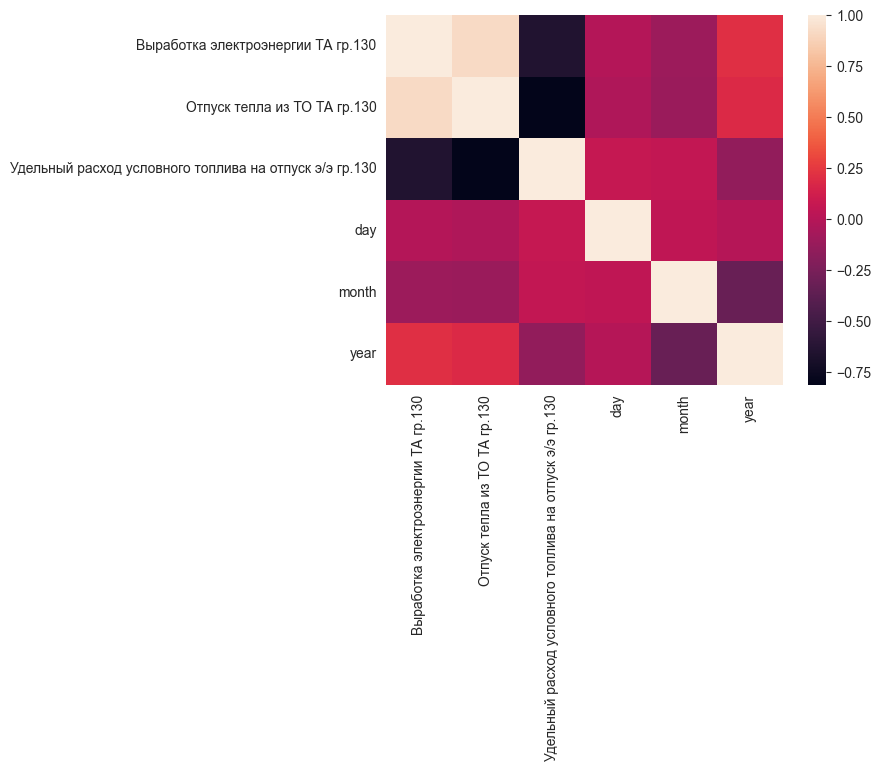

In [287]:
sns.heatmap(data.corr());

# Создание датасета для обучения
## Разделение данных

In [288]:
X = data.drop(target, axis=1)

In [289]:
y = data[target]

In [290]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

## Обучение и предсказания

In [292]:
model = XGBRegressor()

In [293]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [294]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

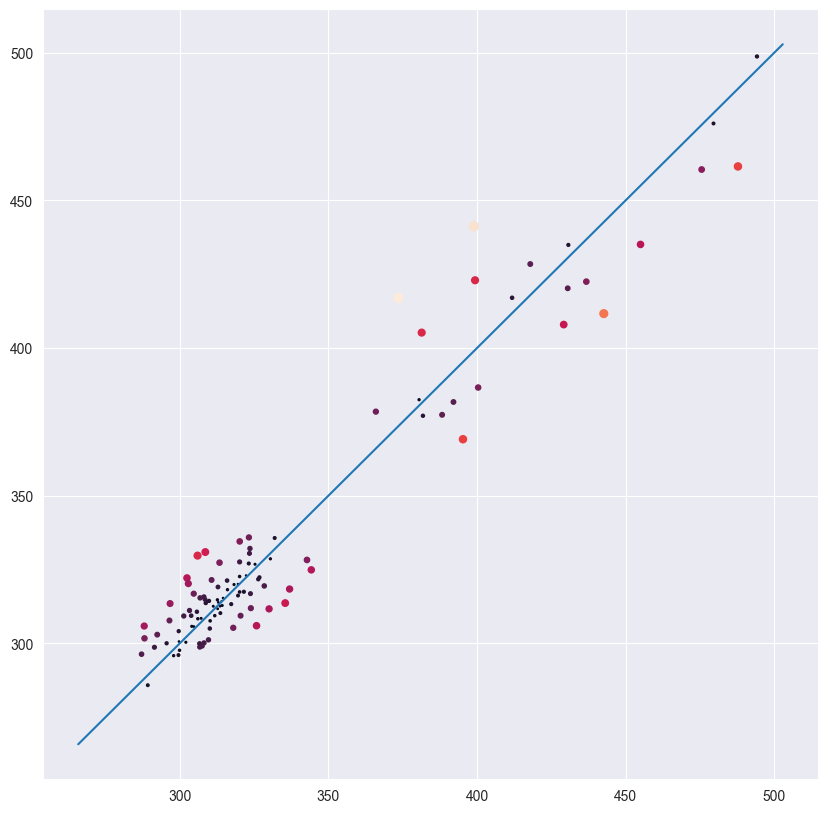

In [295]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [296]:
predictions = np.array(model.predict(X_test))

In [297]:
# data["predictions"] = predictions
# data.to_excel("Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

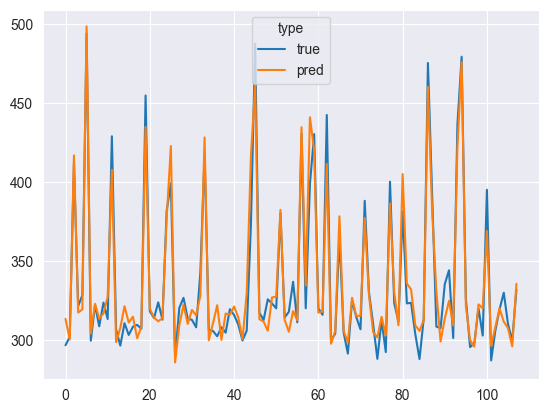

In [298]:
plt.plot(y_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [299]:
r2_score(y_test, predictions)

0.9328376125849612

In [300]:
for i in zip(y_test, predictions):
    if abs(i[0] - i[1]) > 20:
        print(i[0], i[1])

429.177924 407.9537
399.351261 422.95792
306.008378 329.7293
373.586281 417.0085
487.790583 461.49664
398.954059 441.2301
442.660007 411.66263
381.400733 405.2364
308.615473 330.94073
335.490818 313.66092
395.289493 369.14062


In [301]:
abs(y_test - predictions).max()

43.42223340429689

In [302]:
model = XGBRegressor()

In [303]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [304]:
predictions = np.array(model.predict(X))

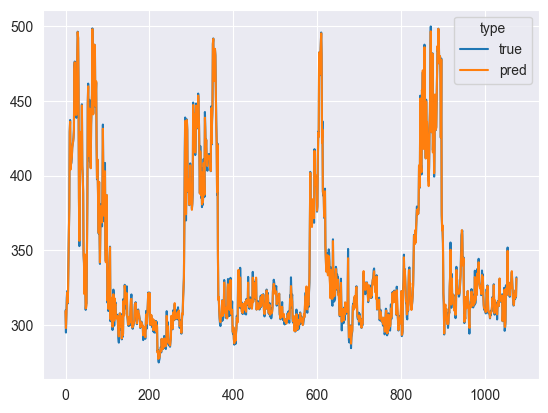

In [305]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [306]:
r2_score(y, predictions)

0.9988680230461983

In [307]:
for i in zip(y, predictions):
    if abs(i[0] - i[1]) > 20:
        print(i[0], i[1])

In [308]:
abs(y - predictions).max()

7.513084378906228

In [309]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [310]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

In [311]:
excel = XGBtoExcel(model)
# feature_map = {'x1': 'Выработка электроэнергии ТА гр.130', 'x2': 'Отпуск тепла из ТО ТА гр.130'}
# excel.rename_features(feature_map)
excel.save_expr("models/xgb0.99.txt")

Saved!


In [312]:
len(XGBtoExcel(model).expression)

110257

In [313]:
linear_model = LinearRegression()

In [314]:
linear_model.fit(X, y)

LinearRegression()

In [315]:
predictions = np.array(linear_model.predict(X))

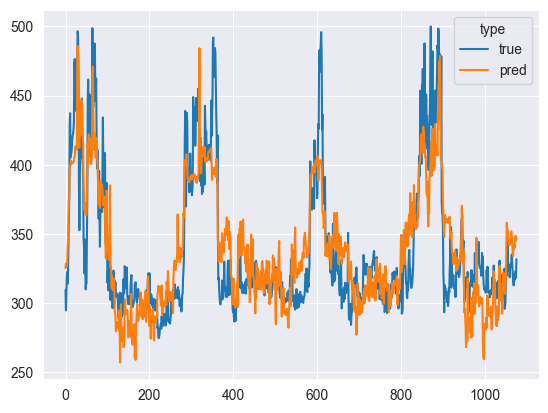

In [316]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [317]:
r2_score(y, predictions)

0.7138575021179454

In [318]:
linear_model.intercept_

4108.788880144466

In [319]:
linear_model.coef_

array([ 0.5140293 , -0.70330939,  0.22503444, -0.67860942, -1.83667031])